# Running the QRF Model 


    The model is based off the paper Srikumar et al., "A kernel-based quantum random forest for improved classification", (2022).
    The code is run on a dataset that is used to predict for heart diseases

In [31]:
from quantum_random_forest import QuantumRandomForest, set_multiprocessing
from split_function import SplitCriterion
from data_construction import data_preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, datasets

## Load dataset

Here you can load your own dataset. The preprocessing can be left untouched. However, it is important to note that certain embeddings require data of certain dimension. PCA reduction to the required dimension can be achieved by changing the X_dim variable. 

In [32]:
import pandas as pd

data = pd.read_csv('heart.csv')
num_classes = 2
X = data.drop(columns='output')
y = data['output']

### Data pre-processing

In [33]:
training_set, testing_set = data_preprocessing(X, y, 
                                               train_prop=0.75,        # Proportion of dataset allocated for training
                                               X_dim=6)                # Determine the required dimension of the dataset. None for default.

New datapoint dimension: 6


## Model parameters 

In [34]:
n_qubits = 6                                         # Number of qubits for the embedding
dt_type = 'qke'                                      # Do not touch
ensemble_var = None                                  # Do not touch
branch_var = ['eff_anz_pqc_arch', 
              'iqp_anz_pqc_arch', 
              'eff_anz_pqc_arch']                    # Type of Anzatz, or as a list for different down the tree - as given 
num_trees = 100                                        # Number of trees in ensemble 
split_num = 2                                        # Do not touch
pqc_sample_num = 2024                                # Number of circuit samples per kernel estimation
num_classes = num_classes                            # Number of classes in dataset
max_depth = 4                                        # Maximum depth of the tree
num_params_split = n_qubits*(n_qubits +1)            # Number of parameters in the embedding (different for different anzatz), list for different down the tree [2 * n_qubits ** 2 , n_qubits*(n_qubits +1), 2 * n_qubits ** 2]
num_rand_gen = 1                                     # Do not touch
num_rand_meas_q = n_qubits                           # Do not touch 
svm_num_train = 5                                    # L, Number of Landmarks
svm_c = 10                                           # C term in SVM optimisation, or list down the tree [100, 50, 20]
min_samples_split = svm_num_train                    # Minimum number of samples
embedding_type = ['as_params_all', 
                  'as_params_iqp', 
                  'as_params_all']                   # Type of embedding, or as a list - as given
criterion = SplitCriterion.init_info_gain('clas')    # Do not touch
device = 'cirq'                                      # Choose a device. Also possible to run on IBM

## Set up model

In [35]:
qrf = QuantumRandomForest(n_qubits, 'clas', num_trees, criterion, max_depth=max_depth, 
                          min_samples_split=min_samples_split, tree_split_num=split_num, num_rand_meas_q=num_rand_meas_q,
                          ensemble_var=ensemble_var, dt_type=dt_type, num_classes=num_classes, ensemble_vote_type='ave',
                          num_params_split=num_params_split, num_rand_gen=num_rand_gen, pqc_sample_num=pqc_sample_num,
                          embed=embedding_type, branch_var=branch_var, svm_num_train=svm_num_train, svm_c=svm_c, 
                          nystrom_approx=True, device=device)

## Train

In [36]:
cores = 3
set_multiprocessing(True, cores)                   # Set to False if you don't want parallel computation
qrf.train(training_set, 
          partition_sample_size=180)               # Partition size is the number of instances given to each tree. Set to None to use all the data for all trees

## Test

In [37]:
acc, preds_qrf = qrf.test(testing_set, 
                          ret_pred=True, 
                          parallel=False,            # Set to False if you don't want parallel computation. Needs to be False for calc_tree_corr to be True.
                          calc_tree_corr=True)       # True is required to later look at correlations between trees

  0%|          | 0/76 [00:00<?, ?it/s]

100%|██████████| 76/76 [1:54:06<00:00, 90.08s/it] 


In [42]:
# Classification report
print(f"Classification report for QRF:\n"
      f"{metrics.classification_report(testing_set.y, preds_qrf)}\n")

Classification report for QRF:
              precision    recall  f1-score   support

           0       0.83      0.69      0.75        35
           1       0.77      0.88      0.82        41

    accuracy                           0.79        76
   macro avg       0.80      0.78      0.78        76
weighted avg       0.79      0.79      0.79        76




## Further analysis of model

In [43]:
# Print out tree
qrf.print_trees()


 ---------------------------------------- 

`- () - 180 instances
   |- () - 165 instances
   |  |- () - 27 instances
   |  |  |- ({0: 0.91, 1: 0.09}) - 23 instances
   |  |  `- ({0: 0.0, 1: 1.0}) - 4 instances
   |  `- () - 138 instances
   |     |- ({0: 0.36, 1: 0.64}) - 137 instances
   |     `- ({0: 1.0, 1: 0.0}) - 1 instances
   `- () - 15 instances
      |- () - 14 instances
      |  |- ({0: 0.85, 1: 0.15}) - 13 instances
      |  `- ({0: 0.0, 1: 1.0}) - 1 instances
      `- ({0: 0.0, 1: 1.0}) - 1 instances

 ---------------------------------------- 

`- () - 180 instances
   |- () - 72 instances
   |  |- () - 71 instances
   |  |  |- ({0: 0.23, 1: 0.77}) - 71 instances
   |  |  `- ({0: 0.23, 1: 0.77}) - 0 instances
   |  `- ({0: 1.0, 1: 0.0}) - 1 instances
   `- () - 108 instances
      |- () - 107 instances
      |  |- ({0: 0.61, 1: 0.39}) - 102 instances
      |  `- ({0: 0.4, 1: 0.6}) - 5 instances
      `- ({0: 0.0, 1: 1.0}) - 1 instances

 ----------------------------------

Class 0


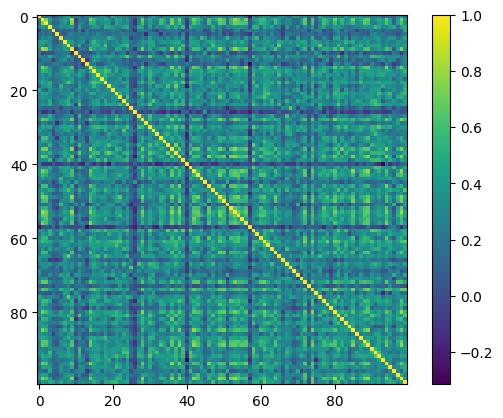

Class 1


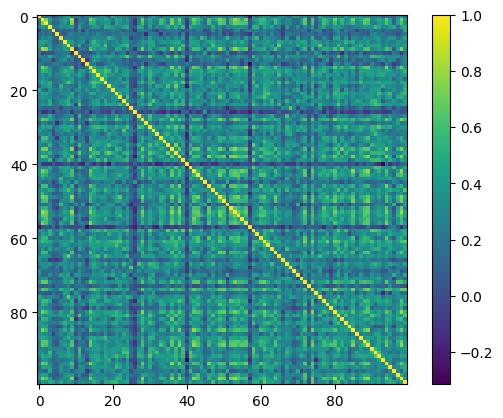

In [44]:
corr_dict = qrf.compute_tree_correlation()
for k,v in corr_dict.items():
    print("Class", k)
    plt.imshow(v)
    plt.colorbar()
    plt.show()